In [5]:
## Import all necessary libraries
from src.models.cv import model_run
from src.utils.config import load_config
from src.data.load import load_weekly_sales
from sklearn.metrics import r2_score, mean_squared_error,root_mean_squared_error
import argparse
import pandas as pd
from src.features.feature_validation import collinearity_test, check_stationary
from src.features.feature_processing import add_thanksgiving_christmas_flags, month_start_flag 
from sklearn.model_selection import ParameterGrid
from joblib import Parallel, delayed
from difflib import get_close_matches
import matplotlib.pyplot as plt
from scipy.stats import f_oneway
from src.viz.visualize_data import plot_train_test_forecast, plot_exog_coefficients
from src.metrics.compute_metrics import cal_mape, cal_smape
from src.models.cv import model_run, endog_exog_split


## Motivation: In this notebook, we will build a model to predict the forecast of weekly sales for next eleven weeks and also determine the expgenous feature which has a high $ impact on the weekly sales. The dataset contains the weekly sales of 45 walmart stores, for a quick walkthrough of the idea, we will only focus on store 1. 

## We will go through the process of feautre selection, cross validation, parameter optimization and final model evaluation.

### Load dataset

In [6]:
## Loading parameters from config
args = {"config": "configs/Params_set.yml"}

cfg = load_config(args["config"])


In [7]:
## Load the dataset
df = load_weekly_sales(cfg["data"]["path_file"],
                      cfg["data"]["index_col"],
                      cfg["data"]["target_var"])

# Extract year and month from date
year = df.index.year
month = df.index.month
unique_years = year.unique()

In [8]:
# Extracting store1 data
df_store = df.loc[df["Store"]==1,].copy()

In [9]:
df_store.head(5)

,Store,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment,y
Date,,,,,,,
2010-02-05,1,0,42.31,2.572,211.096358,8.106,1643690.90
2010-02-12,1,1,38.51,2.548,211.242170,8.106,1641957.44
2010-02-19,1,0,39.93,2.514,211.289143,8.106,1611968.17
2010-02-26,1,0,46.63,2.561,211.319643,8.106,1409727.59
2010-03-05,1,0,46.50,2.625,211.350143,8.106,1554806.68


### Feature selection and feature engineering

In [10]:
# Get variables with >5 VIF and remove it from the consideration list of exogenous variables.
print("Variables of store1",df_store.columns)

num_featrs = ["Temperature", "Fuel_Price", "Unemployment", "CPI","y"]

# Handling collinearity of exogenous variables 
if len(num_featrs) > 1:
    rm_feature = collinearity_test( df_store)
    if rm_feature!="":
        num_featrs.remove(rm_feature )
        df_store.drop(rm_feature, axis = 1, inplace = True)

print("Variables after removing the collinear variables",df_store.columns)

Variables of store1 Index(['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'y'],
      dtype='object')
Variables after removing the collinear variables Index(['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'Unemployment',
       'y'],
      dtype='object')


In [11]:
# Check for stationary and keep final differenced variables
for col in num_featrs:
     pval = check_stationary(df_store[col], col)
     diff_no = 1
     name = col
     while pval > 0.05 and diff_no<=2:
          df_store[f'{col}_diff_{diff_no}'] = df_store[name].diff()
          pval = check_stationary(df_store[f'{col}_diff_{diff_no}'], name)
          df_store.drop(name, axis = 1, inplace=True)
          name = f'{col}_diff_{diff_no}'
          diff_no+=1
df_store = df_store.dropna()
print("Variables after differencing if found non-stationary",df_store.columns)

Variables after differencing if found non-stationary Index(['Store', 'Holiday_Flag', 'Temperature', 'y', 'Fuel_Price_diff_1',
       'Unemployment_diff_2'],
      dtype='object')


In [12]:

# if any of the num features are modified, add the modified names in num_features
modified_var = [var for var in num_featrs if var not in df_store.columns]

for var in modified_var:
    match = get_close_matches(var, df_store.columns, n=1, cutoff=0.1)
    if match:
        num_featrs.append(match[0])
        num_featrs.remove(var)
print("Modifying num_feaures with differenced variables", num_featrs)
  

Modifying num_feaures with differenced variables ['Temperature', 'y', 'Fuel_Price_diff_1', 'Unemployment_diff_2']


### Although we already have a general holiday flag as exogenous variable, Thanksgiving and Christmas were separated into their own indicators because they show uniquely strong and consistent sales effects compared to other holidays. A single holiday flag would dilute these high-impact events with lower-impact holidays, leading to biased estimates.

In [13]:
# Add thanksgiving and christmas flags
df_store.loc[df_store.index.month.isin([11, 12]), "Holiday_Flag"] = 0

   
df_store = add_thanksgiving_christmas_flags(
                df_store,
                week_anchor="FRI",
                windows={"thanksgiving":[0], "christmas":[-1,0]},
                col_prefix="cal_"
        )
        
# Add month start sale flags
Month_Start_Flag = month_start_flag(df_store.index)
df_store['Month_Start_Flag'] = Month_Start_Flag

binary_featrs = ["Holiday_Flag", "Month_Start_Flag", "cal_thanksgiving_w0", "cal_christmas_w-1","cal_christmas_w0" ]


### Parameters selection

### We fixed D=1 from seasonal tests (annual weekly seasonality), kept d=0 after confirming non-seasonal stationarity, and searched parsimonious AR/MA orders p,q,P,Q ∈ {0,1,2} by AICc, then validated the top models via walk-forward CV on RMSE/SMAPE and R2.

In [14]:
model_param = {'p': [0,1,2],
              'd': [0],
              'q': [0,1,2],
              'P': [0,1,2],
              'D': [1],
              'Q': [0,1,2]}
param = model_param 

In [15]:
## Grid search for parameter optimization
grid = ParameterGrid(param)

results = Parallel(n_jobs=-2, verbose=10)(
            delayed(model_run)(df_store, params, num_featrs,  binary_featrs ) for params in grid
        )      
        
best = min(results, key=lambda x: x["rmse"])

best_params = best["params"]

print(best_params)


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-2)]: Done  20 tasks      | elapsed:   55.0s
/Users/rubysharma/opt/anaconda3/envs/walmart_forecasting/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-2)]: Done  31 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-2)]: Done  42 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-2)]: Done  61 out of  81 | elapsed:  7.1min remaining:  2.3min
[Parallel(n_jobs=-2)]: Done  70 out of  81 | elapsed: 10.0min remaining:  1.6min
[Parallel(n_jobs=-2)]: Done  79 out of  81 | elapsed: 11.0min remaining:   16.7s


[1, 1, 0, 0, 1, 2]


[Parallel(n_jobs=-2)]: Done  81 out of  81 | elapsed: 11.4min finished


In [16]:
best_params =dict()
best_params = {"D": best["params"][0], "P": best["params"][1], "Q": best["params"][2], "d": best["params"][3], "p": best["params"][4], "q": best["params"][5]}


### Final train and test using the best parameters

In [17]:
print(num_featrs)
print(binary_featrs)

features = num_featrs + binary_featrs
periods = 21

# Spilitting data into train and test
train = df_store.iloc[:-periods,]
test = df_store.iloc[-periods:,]

train = train.loc[:,features]
test = test.loc[:,features]

# Split data into endog and exog dataframes
Srmx_model, forecast,  preprocessor, x_scld_train, x_scld_test, y_scld_train, y_scld_test  = endog_exog_split(train, test, num_featrs, binary_featrs, best_params)
y_predicted = forecast.predicted_mean
y_pred_ci = forecast.conf_int().astype(float)  


['Temperature', 'y', 'Fuel_Price_diff_1', 'Unemployment_diff_2']
['Holiday_Flag', 'Month_Start_Flag', 'cal_thanksgiving_w0', 'cal_christmas_w-1', 'cal_christmas_w0']


/Users/rubysharma/opt/anaconda3/envs/walmart_forecasting/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/rubysharma/opt/anaconda3/envs/walmart_forecasting/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/rubysharma/opt/anaconda3/envs/walmart_forecasting/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rubysharma/opt/anaconda3/envs/walmart_forecasting/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as 

### Final model evalutation using rmse, mape, smape and r2 score.

In [18]:

# calculate the model evaluation metrics
rmse = root_mean_squared_error(y_scld_test, y_predicted)
mape = cal_mape(y_scld_test, y_predicted)
smape = cal_smape(y_scld_test, y_predicted)
r2 = r2_score(y_scld_test, y_predicted)


In [19]:
print("RMSE", rmse)
print("SMAPE", smape)
print("R2", r2)


RMSE 0.06383421358405413
SMAPE 30.261355679543527
R2 0.34578509880584196


### Plot train, test with confidence interval

(<Axes: title={'center': 'Sales Forecast Scaled'}, xlabel='Date', ylabel='Weekly Sales ($)'>,
 (0.06383421358405413, 0.34578509880584196, np.float64(30.261355679543527)))

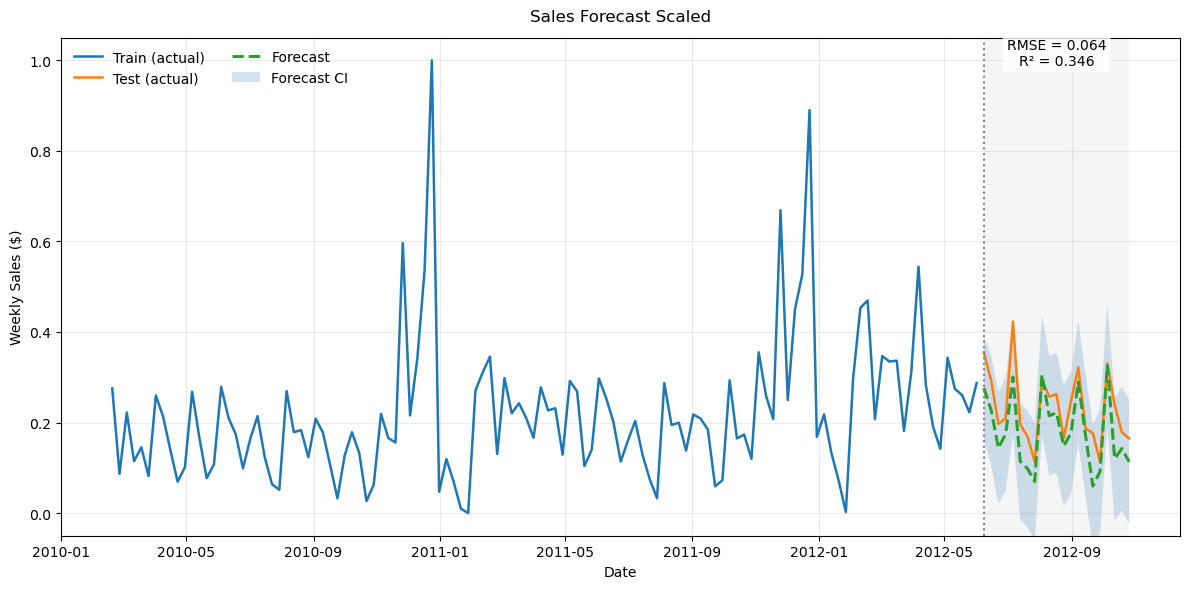

In [20]:
plot_train_test_forecast(y_scld_train, y_scld_test, y_predicted , conf_int=y_pred_ci, 
                                        title="Sales Forecast Scaled", ylabel="Weekly Sales ($)", r2 =r2, rmse = rmse, smape=smape )   
        


### Plot exogenous regressor coefficients with their p-values

In [21]:
Key_regressors = ['Temperature', 'Fuel_Price_diff_1', 'Unemployment_diff_2', 'Holiday_Flag', 'Month_Start_Flag', 'cal_thanksgiving_w0', 'cal_christmas_w-1', 'cal_christmas_w0']

print(Key_regressors)

# get index of column of y
if "y" in train.columns:
     loc_y = train.columns.get_loc("y")
else:
     loc_y = train.columns.get_loc("y_diff_1")  

data_range = preprocessor.data_range_[loc_y]
            
     # get regressor coeffs based on scaled target variable
org_coeff = pd.concat([Srmx_model.params[Key_regressors], Srmx_model.pvalues[Key_regressors],
                            Srmx_model.conf_int().loc[Key_regressors][0], 
                            Srmx_model.conf_int().loc[Key_regressors][1]],axis=1)
org_coeff.columns = ["Coef", "Pvalue", "CI_lower", "CI_upper"]  

['Temperature', 'Fuel_Price_diff_1', 'Unemployment_diff_2', 'Holiday_Flag', 'Month_Start_Flag', 'cal_thanksgiving_w0', 'cal_christmas_w-1', 'cal_christmas_w0']


<Axes: title={'center': 'Exog Coefficients scaled'}, xlabel='Coefficient', ylabel='Variable'>

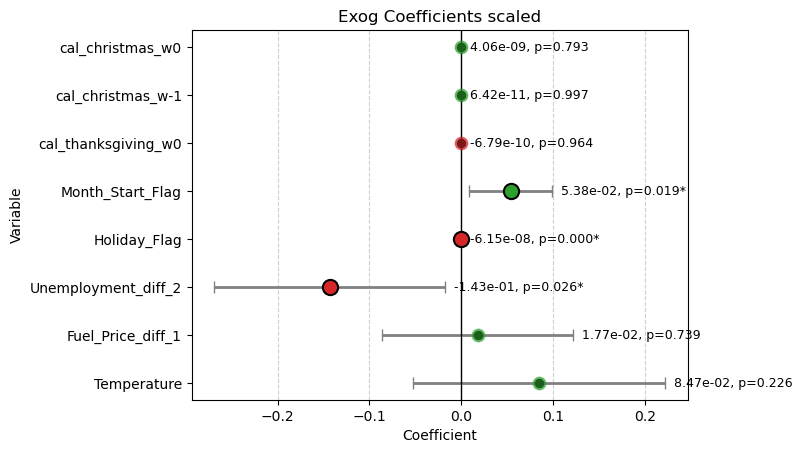

In [22]:
fig, ax = plt.subplots()
plot_exog_coefficients( ax, org_coeff, title="Exog Coefficients scaled")

### The SARIMAX model using all exogenous variables has r2 of 0.3, RMSE of 0.063 and SMAPE of 30.26. The model is not performing well. Only few exogenous variables like month_start_flag, holiday_flag has significant positive impact on the weekly sales of store 1. We will again create a SARIMAX model, using only month_start_flag, holiday_flag, thanksgiving and christmas flags to avoid any bias coming from features like fuel price, temperature, and unemployment. We aim to keep the model simple and make it easy to extrapolate exogenous variables for future forecasts

In [23]:
# Extracting store1 data
df_store = df.loc[df["Store"]==1,].copy()


# Get variables with >5 VIF and remove it from the consideration list of exogenous variables.
print("Variables of store1",df_store.columns)

num_featrs = ["y"]

# Handling collinearity of exogenous variables 
if len(num_featrs) > 1:
    rm_feature = collinearity_test( df_store)
    if rm_feature!="":
        num_featrs.remove(rm_feature )
        df_store.drop(rm_feature, axis = 1, inplace = True)

print("Variables after removing the collinear variables",df_store.columns)

Variables of store1 Index(['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'y'],
      dtype='object')
Variables after removing the collinear variables Index(['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'y'],
      dtype='object')


In [24]:
# Check for stationary and keep final differenced variables
for col in num_featrs:
     pval = check_stationary(df_store[col], col)
     diff_no = 1
     name = col
     while pval > 0.05 and diff_no<=2:
          df_store[f'{col}_diff_{diff_no}'] = df_store[name].diff()
          pval = check_stationary(df_store[f'{col}_diff_{diff_no}'], name)
          df_store.drop(name, axis = 1, inplace=True)
          name = f'{col}_diff_{diff_no}'
          diff_no+=1
df_store = df_store.dropna()
print("Variables after differencing if found not stationary",df_store.columns)

Variables after differencing if found not stationary Index(['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI',
       'Unemployment', 'y'],
      dtype='object')


In [25]:
# if any of the num features are modified, add the modified names in num_features
modified_var = [var for var in num_featrs if var not in df_store.columns]

for var in modified_var:
    match = get_close_matches(var, df_store.columns, n=1, cutoff=0.1)
    if match:
        num_featrs.append(match[0])
        num_featrs.remove(var)
print("Modifying num_feaures with differenced variables", num_featrs)

Modifying num_feaures with differenced variables ['y']


In [26]:
# Add thanksgiving and christmas flags
df_store.loc[df_store.index.month.isin([11, 12]), "Holiday_Flag"] = 0

   
df_store = add_thanksgiving_christmas_flags(
                df_store,
                week_anchor="FRI",
                windows={"thanksgiving":[0], "christmas":[-1,0]},
                col_prefix="cal_"
        )
        
# Add month start sale flags
Month_Start_Flag = month_start_flag(df_store.index)
df_store['Month_Start_Flag'] = Month_Start_Flag

binary_featrs = ["Holiday_Flag", "Month_Start_Flag", "cal_thanksgiving_w0", "cal_christmas_w-1","cal_christmas_w0" ]


In [27]:
model_param = {'p': [0,1,2],
              'd': [0],
              'q': [0,1,2],
              'P': [0,1,2],
              'D': [1],
              'Q': [0,1,2]}
param = model_param 

In [28]:

grid = ParameterGrid(param)

results = Parallel(n_jobs=-2, verbose=10)(
            delayed(model_run)(df_store, params, num_featrs,  binary_featrs ) for params in grid
        )      
        
best = min(results, key=lambda x: x["rmse"])

best_params = best["params"]

print(best_params)

[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-2)]: Done  11 tasks      | elapsed:   13.7s
/Users/rubysharma/opt/anaconda3/envs/walmart_forecasting/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-2)]: Done  20 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-2)]: Done  31 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-2)]: Done  42 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-2)]: Done  61 out of  81 | elapsed:  7.1min remaining:  2.3min
[Parallel(n_jobs=-2)]: Done  70 out of  81 | elapsed:  9.2min remaining:  1.4min
[Parallel(n_jobs=-2)]: Done  79 out of  81 | elapsed: 11.2min remaining:   17.0s


[1, 1, 1, 0, 1, 2]


[Parallel(n_jobs=-2)]: Done  81 out of  81 | elapsed: 11.9min finished


In [29]:
best_params =dict()
best_params = {"D": best["params"][0], "P": best["params"][1], "Q": best["params"][2], "d": best["params"][3], "p": best["params"][4], "q": best["params"][5]}


In [30]:
print(num_featrs)
print(binary_featrs)

features = num_featrs + binary_featrs
periods = 21

# Spilitting data into train and test
train = df_store.iloc[:-periods,]
test = df_store.iloc[-periods:,]

train = train.loc[:,features]
test = test.loc[:,features]

# Split data into endog and exog dataframes
Srmx_model, forecast,  preprocessor, x_scld_train, x_scld_test, y_scld_train, y_scld_test  = endog_exog_split(train, test, num_featrs, binary_featrs, best_params)
y_predicted = forecast.predicted_mean
y_pred_ci = forecast.conf_int().astype(float)  


['y']
['Holiday_Flag', 'Month_Start_Flag', 'cal_thanksgiving_w0', 'cal_christmas_w-1', 'cal_christmas_w0']


/Users/rubysharma/opt/anaconda3/envs/walmart_forecasting/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/rubysharma/opt/anaconda3/envs/walmart_forecasting/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-FRI will be used.
  self._init_dates(dates, freq)
/Users/rubysharma/opt/anaconda3/envs/walmart_forecasting/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rubysharma/opt/anaconda3/envs/walmart_forecasting/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as 

In [31]:
# calculate the model evaluation metrics
rmse = root_mean_squared_error(y_scld_test, y_predicted)
mape = cal_mape(y_scld_test, y_predicted)
smape = cal_smape(y_scld_test, y_predicted)
r2 = r2_score(y_scld_test, y_predicted)


In [32]:
print("RMSE", rmse)
print("SMAPE", smape)
print("R2", r2)


RMSE 0.03551818691326842
SMAPE 12.559323630066913
R2 0.7974580514081702


(<Axes: title={'center': 'Sales Forecast Scaled'}, xlabel='Date', ylabel='Weekly Sales ($)'>,
 (0.03551818691326842, 0.7974580514081702, np.float64(12.559323630066913)))

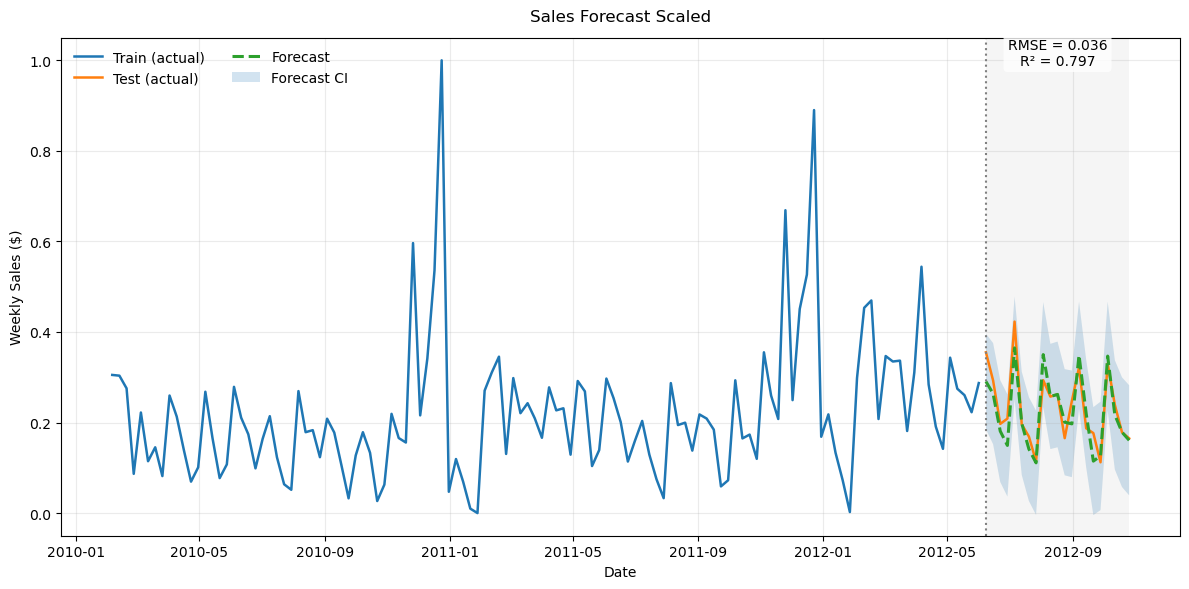

In [33]:
plot_train_test_forecast(y_scld_train, y_scld_test, y_predicted , conf_int=y_pred_ci, 
                                        title="Sales Forecast Scaled", ylabel="Weekly Sales ($)", r2 =r2, rmse = rmse, smape=smape )   
  

In [34]:
Key_regressors = ['Holiday_Flag', 'Month_Start_Flag', 'cal_thanksgiving_w0', 'cal_christmas_w-1', 'cal_christmas_w0']

print(Key_regressors)

# get index of column of y
if "y" in train.columns:
     loc_y = train.columns.get_loc("y")
else:
     loc_y = train.columns.get_loc("y_diff_1")  


print(loc_y)
data_range = preprocessor.data_range_[loc_y]
            
     # get regressor coeffs based on scaled target variable
org_coeff = pd.concat([Srmx_model.params[Key_regressors], Srmx_model.pvalues[Key_regressors],
                            Srmx_model.conf_int().loc[Key_regressors][0], 
                            Srmx_model.conf_int().loc[Key_regressors][1]],axis=1)
org_coeff.columns = ["Coef", "Pvalue", "CI_lower", "CI_upper"]  

['Holiday_Flag', 'Month_Start_Flag', 'cal_thanksgiving_w0', 'cal_christmas_w-1', 'cal_christmas_w0']
0


<Axes: title={'center': 'Exog Coefficients scaled'}, xlabel='Coefficient', ylabel='Variable'>

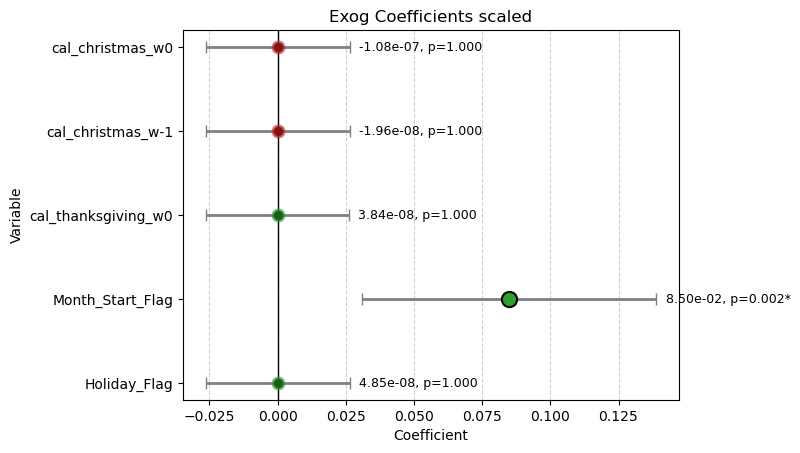

In [35]:
fig, ax = plt.subplots()
plot_exog_coefficients( ax, org_coeff, title="Exog Coefficients scaled")

In [36]:
org_coeff_scl_back = org_coeff.copy()
org_coeff_scl_back[["Coef","CI_lower", "CI_upper"]] =  org_coeff_scl_back[["Coef","CI_lower", "CI_upper"]]*data_range 
meaningful_changes = cfg["final_evaluation"]["meaningful_changes"]
# Add business impact calculations
org_coeff_scl_back["Meaningful_Change"] = org_coeff_scl_back.index.map(meaningful_changes)
org_coeff_scl_back["dollar_impact"] = org_coeff_scl_back["Coef"] * org_coeff_scl_back["Meaningful_Change"]

            
# rmse scaled back to orginal target variable
rmse_org_scale =  rmse * data_range 
metric_store = {"rmse": rmse, "mape":mape, "smape": smape,"r2":r2, "rmse_org_scale": rmse_org_scale}

## The dollar impact of all the coefficients, transformed to original scale

In [37]:
print(org_coeff_scl_back)

                             Coef    Pvalue      CI_lower       CI_upper  \
Holiday_Flag             0.051989  0.999997 -28235.769649   28235.873627   
Month_Start_Flag     91008.453493  0.002021  33228.450082  148788.456904   
cal_thanksgiving_w0      0.041182  0.999998 -28209.438929   28209.521292   
cal_christmas_w-1       -0.021022  0.999999 -28253.355476   28253.313431   
cal_christmas_w0        -0.115949  0.999994 -28306.131610   28305.899712   

                     Meaningful_Change  dollar_impact  
Holiday_Flag                       1.0       0.051989  
Month_Start_Flag                   1.0   91008.453493  
cal_thanksgiving_w0                1.0       0.041182  
cal_christmas_w-1                  1.0      -0.021022  
cal_christmas_w0                   1.0      -0.115949  


In [38]:
print(rmse_org_scale)

38041.7857046425


## Conclusion: 
## 1. We created a SARIMAX model for store1 weekly sales.
## 2. We observed that weekly sales is high at the start of each month.
## 3. The $ impact of month_start_flag is $91,008.453
## 4. The model is fairly good with r2 of 0.794, rmse of $38,041 and smape of 12%. 
## 5. We did not find any significant high impact of any other exogenous variables on weekly sales.
## 6. The scripts folder has code to create model for all 45 stores. In the end, we have categorized the stores in four categories based on their regressor $ imapct on weekly sales, confidence interval, p-value and evaluation scores. 

### Created By: Ruby Sharma